In [1]:
!rm -rf ./ML4CV_XAI
!git clone https://github.com/liuktc/ML4CV_XAI.git
!pip install captum grad_cam Craft-xai torcheval
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('/kaggle/working/ML4CV_XAI')

Cloning into 'ML4CV_XAI'...
remote: Enumerating objects: 818, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 818 (delta 6), reused 19 (delta 5), pack-reused 789 (from 1)
Receiving objects: 100% (818/818), 63.56 MiB | 39.13 MiB/s, done.
Resolving deltas: 100% (359/359), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 12.2 MB/s eta 0:00:00
  Created wheel for grad_cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39680 sha256=0a68309590a3edf4e79646b401573e3d306ac48f301b6b3a2c46364d5a4b2a7a
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successf

In [1]:
%load_ext autoreload

%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader

from utils import _DeepLiftShap, _GradCAMPlusPlus, SimpleUpsampling,ERFUpsamplingFast, min_max_normalize
from data import imagenettewoof
from results.results_metrics import ResultMetrics
from models import vgg11_PascalVOC, vgg_preprocess, vgg11_Imagenettewoof

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

In [2]:
model = vgg11_Imagenettewoof()
model.to(device)
# Load the pretrained weights
model.load_state_dict(torch.load('./VGG11_PascalVOC.pt', map_location=device))
model.eval()

preprocess = vgg_preprocess

In [3]:
train_data = imagenettewoof(split="train",size="320px",download=False, transform=preprocess)
test_data = imagenettewoof(split="test",size="320px", download=False, transform=preprocess)

data\imagewoof2-320
data\imagewoof2-320


In [4]:
###########################################
###########################################
###########################################
###########################################
## TO CHANGE IN KAGGLE
INDEX = 0 # 0,1,2,3
###########################################
###########################################
###########################################
###########################################

# Number of parts to split the dataset into
num_parts = 4

# Get the total number of images in the dataset
total_size = len(test_data)

# Split the dataset indices into roughly equal parts
split_indices = np.array_split(np.arange(total_size), num_parts)

INDICES = split_indices[INDEX]

In [5]:
import torch.utils
from torch.utils.data import Subset

# BATCH_SIZE_TEST = 1

BATCH_SIZE_TRAIN = 2
NUM_TRAIN = 16

# dl_test = DataLoader(test_data, batch_size=BATCH_SIZE_TEST, shuffle=False)
dl_train = DataLoader(Subset(train_data, torch.randperm(len(train_data))[:NUM_TRAIN]), batch_size=BATCH_SIZE_TRAIN, shuffle=False)

In [6]:
baseline_dist_16 = torch.cat([images for images, _ in dl_train], dim=0).to(device)
baseline_dist_8 = baseline_dist_16[:8].clone()
baseline_dist_4 = baseline_dist_16[:4].clone()

In [21]:
LAYERS = [5]

Results loaded from ./results_fake.csv.


  0%|          | 0/1 [00:00<?, ?it/s]

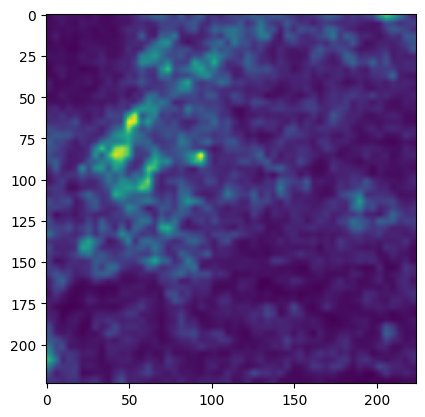

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


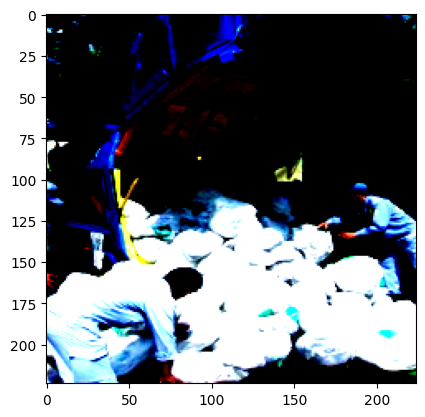

AssertionError: 

In [22]:
from metrics import RoadCombined, Infidelity, Sensitivity, AverageDrop, InsertionCurveAUC, DeletionCurveAUC
from utils import MultiplierMix, _ScoreCAM, _EigenCAM, _LayerCAM
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt

results = ResultMetrics("./results_fake.csv")

last_image_index = results.get_last_image_index()

# for index in tqdm(INDICES):
for index in tqdm([4]):

    if index < last_image_index:
        continue
    images, labels = test_data[index]
    images = images.unsqueeze(0)  # Add batch dimension
    labels = torch.Tensor([labels]).long()  # Convert to long tensor    
    images = images.to(device)
    labels = labels.to(device).reshape(-1)

    predicted_label = model(images).argmax(dim=1)

    # Make sure that LAYERS is sorted in descending order
    LAYERS.sort(reverse=True)
    # for attribution_method in [_DeepLiftShap(baseline_dist_8, name="DeepLiftShap8"), _GradCAMPlusPlus()]:
    # for attribution_method in [_GradCAMPlusPlus()]:   
    # for attribution_method in [_ScoreCAM()]:
    # for attribution_method in [_EigenCAM()]:   
    # for attribution_method in [_ShapleyCAM()]:    
    for attribution_method in [_LayerCAM()]:
        # for upsample_method in [ERFUpsamplingFast(), SimpleUpsampling((224,224))]:
        for upsample_method in [SimpleUpsampling((224,224))]:
        
            attributions_per_layer = []
            for layer_index in LAYERS:
                layer = model.features[layer_index]
                attribution_map = attribution_method.attribute(input_tensor=images,
                                                                model=model,
                                                                layer=layer,
                                                                target=labels
                                                                )
                

                # upsample_method = SimpleUpsampling((224,224))
                attribution_map = upsample_method(attribution=attribution_map,
                                                  image=images,
                                                  device=device,
                                                  model=model,
                                                  layer=layer)
                
                plt.imshow(attribution_map[0,0].cpu().detach().numpy())
                plt.show()
                plt.imshow(images[0].cpu().detach().numpy().transpose(1,2,0))
                plt.show()

                assert(False)
                

                if (torch.abs(
                    attribution_map.amax(dim=(2, 3), keepdim=True)
                    - attribution_map.amin(dim=(2, 3), keepdim=True)
                )
                < 1e-6  ).any():
                    print("A saliency map is constant, skipping batch")
                    del images, labels, attribution_map
                    torch.cuda.empty_cache()
                    continue

                attribution_map = min_max_normalize(attribution_map)
                print(attribution_map.shape)

                attributions_per_layer.append(attribution_map)

                # Mix the attribution maps
                mix = MultiplierMix(layers_to_combine="all")
                mixed_attribution_map = mix(attributions_per_layer)

                for metric in [RoadCombined()]:
                    start_time = time.time()
                    metric_result_normal = metric(model=model,
                            test_images=images,
                            saliency_maps=attribution_map,
                            class_idx=labels,
                            attribution_method=attribution_method,
                            device=device,
                            layer=layer)
                    end_time = time.time()
                    print(f"Time taken for {metric.name}: {end_time - start_time} seconds")
                    
                    results.add_result(model="VGG11",
                                       attribution_method=attribution_method.name,
                                       dataset="Imagenettewoof",
                                       layer=f"features.{layer_index}",
                                       metric=metric.name,
                                       upscale_method=upsample_method.name,
                                       mixing_method= "None",
                                       value=metric_result_normal,
                                       image_index=index,
                                       label=labels[0].item(),
                                       predicted_label=predicted_label[0].item())

                    metric_result_mixed = metric(model=model,
                            test_images=images,
                            saliency_maps=mixed_attribution_map,
                            class_idx=labels,
                            attribution_method=attribution_method,
                            device=device,
                            layer=layer)
                    
                    
                    results.add_result(model="VGG11",
                                       attribution_method=attribution_method.name,
                                       dataset="Imagenettewoof",
                                       layer=f"features.{layer_index}",
                                       metric=metric.name,
                                       upscale_method=upsample_method.name,
                                       mixing_method= mix.name,
                                       value=metric_result_mixed,
                                       image_index=index,
                                       label=labels[0].item(),
                                       predicted_label=predicted_label[0].item())

In [18]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import time

def process_index(index):
    try:
        # Initialize or load any necessary resources locally if needed
        if index < results.get_last_image_index():
            return None

        images, labels = test_data[index]
        images = images.unsqueeze(0)
        labels = torch.Tensor([labels]).long()
        images = images.to(device)
        labels = labels.to(device).reshape(-1)

        predicted_label = model(images).argmax(dim=1)

        LAYERS.sort(reverse=True)
        output = []
        for attribution_method in [_GradCAMPlusPlus()]:
            for upsample_method in [ERFUpsamplingFast(), SimpleUpsampling((224,224))]:
                attributions_per_layer = []
                for layer_index in LAYERS:
                    layer = model.features[layer_index]
                    attribution_map = attribution_method.attribute(
                        input_tensor=images,
                        model=model,
                        layer=layer,
                        target=labels
                    )
                    attribution_map = upsample_method(
                        attribution=attribution_map,
                        image=images,
                        device=device,
                        model=model,
                        layer=layer
                    )
                    if (torch.abs(
                        attribution_map.amax(dim=(2, 3), keepdim=True) -
                        attribution_map.amin(dim=(2, 3), keepdim=True)
                    ) < 1e-6).any():
                        print("A saliency map is constant, skipping batch")
                        continue

                    attribution_map = min_max_normalize(attribution_map)
                    attributions_per_layer.append(attribution_map)

                    mix = MultiplierMix(layers_to_combine="all")
                    mixed_attribution_map = mix(attributions_per_layer)

                    for metric in [RoadCombined()]:
                        start_time = time.time()
                        metric_result_normal = metric(
                            model=model,
                            test_images=images,
                            saliency_maps=attribution_map,
                            class_idx=labels,
                            attribution_method=attribution_method,
                            device=device,
                            layer=layer
                        )
                        end_time = time.time()
                        print(f"Time taken for {metric.name}: {end_time - start_time} seconds")
                        
                        output.append({
                            "model": "VGG11",
                            "attribution_method": attribution_method.name,
                            "dataset": "Imagenettewoof",
                            "layer": f"features.{layer_index}",
                            "metric": metric.name,
                            "upscale_method": upsample_method.name,
                            "mixing_method": "None",
                            "value": metric_result_normal,
                            "image_index": index,
                            "label": labels[0].item(),
                            "predicted_label": predicted_label[0].item()
                        })

                        metric_result_mixed = metric(
                            model=model,
                            test_images=images,
                            saliency_maps=mixed_attribution_map,
                            class_idx=labels,
                            attribution_method=attribution_method,
                            device=device,
                            layer=layer
                        )
                        
                        output.append({
                            "model": "VGG11",
                            "attribution_method": attribution_method.name,
                            "dataset": "Imagenettewoof",
                            "layer": f"features.{layer_index}",
                            "metric": metric.name,
                            "upscale_method": upsample_method.name,
                            "mixing_method": mix.name,
                            "value": metric_result_mixed,
                            "image_index": index,
                            "label": labels[0].item(),
                            "predicted_label": predicted_label[0].item()
                        })
        return output
    except Exception as e:
        print(f"Error processing index {index}: {e}")
        return None

indices_to_process = [i for i in INDICES if i >= results.get_last_image_index()]

all_results = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(process_index, index): index for index in indices_to_process}
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        if result is not None:
            all_results.extend(result)

for res in all_results:
    results.add_result(**res)


  0%|          | 0/4 [00:00<?, ?it/s]

: 

In [11]:
all_results

[{'model': 'VGG11',
  'attribution_method': 'GradCAMPlusPlus',
  'dataset': 'Imagenettewoof',
  'layer': 'features.20',
  'metric': 'road_combined',
  'upscale_method': 'ERFUpsamplingFast',
  'mixing_method': 'None',
  'value': 1.382723e-05,
  'image_index': 3,
  'label': 6,
  'predicted_label': 15},
 {'model': 'VGG11',
  'attribution_method': 'GradCAMPlusPlus',
  'dataset': 'Imagenettewoof',
  'layer': 'features.20',
  'metric': 'road_combined',
  'upscale_method': 'ERFUpsamplingFast',
  'mixing_method': 'MultiplierMix',
  'value': 8.329633e-06,
  'image_index': 3,
  'label': 6,
  'predicted_label': 15},
 {'model': 'VGG11',
  'attribution_method': 'GradCAMPlusPlus',
  'dataset': 'Imagenettewoof',
  'layer': 'features.15',
  'metric': 'road_combined',
  'upscale_method': 'ERFUpsamplingFast',
  'mixing_method': 'None',
  'value': 0.0005787066,
  'image_index': 3,
  'label': 6,
  'predicted_label': 15},
 {'model': 'VGG11',
  'attribution_method': 'GradCAMPlusPlus',
  'dataset': 'Imagenet